# DL2 - Sheet 02: Attention (50 points)



In [1]:
# Install the transformers library if necessary
# !pip install transformers

In [2]:
import torch


# Intro: Transformers for Sequence Classification

In this weeks notebook, we will implement our own Transformer model from scratch. Typical Transformers can be broken down into the following components:
Remark: Here, we will focus on the encoding of sentences for the purpose of sentiment classification, the decoder used in sequence2sequences Transformers has a very similar structure.



1.   Embedding: An embedding layer that transforms word tokens into vector representations.
2.  Encoder: The encoder block consists of several multi-headed attention blocks

    2.1.   Attention block 1

    2.2.   Attention block 2

    ...

    2.L.   Attention block L

3. Pooling: The final output of the encoder computes one vector representation for each token. To further summarize/pool this information for classification, the [CLS] token at sequence position 0 is typically selected.

4. Classification: A standard small MLP is used for classification and outputs probabilites for the most likely predicted class.


## Preparation: From sentences to tokens

First, we will use hugginface's tokenizer to go from words to indices in the vocabulary. In the following, we will focus on the distilBERT model:


In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
sentence = "This was one of the best movies I have ever seen."
inputs = tokenizer(sentence, return_tensors = 'pt')
print(inputs)

{'input_ids': tensor([[ 101, 2023, 2001, 2028, 1997, 1996, 2190, 5691, 1045, 2031, 2412, 2464,
         1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [4]:
tokenizer("fuck")

{'input_ids': [101, 6616, 102], 'attention_mask': [1, 1, 1]}

In [39]:
tokenizer.convert_ids_to_tokens([101, 6616])

['[CLS]', 'fuck']

In [6]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [7]:
# Now we download pretrained weights for the model.
!wget https://tubcloud.tu-berlin.de/s/GfEoq4r8Sgb2727/download/distilbert.pt

/bin/bash: wget: command not found


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
# This config contains the model parameters, it will be important to understand what representations
# have which dimensionality

from torch import nn
import torch
import math
import torch

class Config(object):
    def __init__(self):
        self.n_heads = 12
        self.n_layers = 6
        self.pad_token_id = 0
        self.dim = 768 # num of embedding dimensions for a single token
        self.hidden_dim = 3072
        self.max_position_embeddings = 512 # max length of a sequence
        self.vocab_size = 30522
        self.eps = 1e-12

        self.attention_head_size = int(self.dim / self.n_heads)
        self.all_head_size = self.n_heads * self.attention_head_size

        self.n_classes = 2
        self.device = 'mps' if torch.backends.mps.is_available() else 'cpu'

config = Config()

In [9]:
config.all_head_size == config.dim

True

# 1. Embedding Layer (5p)
Next, we will have to implement the Embedding layer.


1.   forward: compute the output embeddings from the input_embeds and position_embeds. (Think about how they are merged.)




In [10]:
torch.manual_seed(0) # set seed for reproducible random initialization of weights

class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        # these embeddings at random at start, learned during training
        self.word_embeddings = nn.Embedding(config.vocab_size, config.dim, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.dim)
        self.LayerNorm = nn.LayerNorm(config.dim, eps=config.eps)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
            input_ids (torch.Tensor):
                torch.tensor(bs, max_seq_length) The token ids to embed.
        Returns: torch.tensor(bs, max_seq_length, dim) The embedded tokens (plus position embeddings)
        """

        # Embedding the input ids
        input_embeds = self.word_embeddings(input_ids)  # (bs, max_seq_length, dim)
        seq_length = input_embeds.size(1)

        # Creating and embedding the position ids - instead of max_seq_len we could think of len of actual sentence
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)  # (max_seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)  # (bs, max_seq_length)
        position_embeddings = self.position_embeddings(position_ids)  # (bs, max_seq_length, dim)

        # Compute the output embeddings

        # 1. START YOUR CODE HERE #

        embeddings = input_embeds + position_embeddings

        # 1. END YOUR CODE HERE #

        embeddings = self.LayerNorm(embeddings)  # (bs, max_seq_length, dim)
        return embeddings

embedding_layer = Embeddings(config)
# Test if your embedding layer computes an output
embeddings = embedding_layer(inputs['input_ids'])


In [11]:
embeddings.shape

torch.Size([1, 14, 768])

In [12]:
position_embeddings = nn.Embedding(config.max_position_embeddings, config.dim)
word_embeddings = nn.Embedding(config.vocab_size, config.dim, padding_idx=config.pad_token_id)


In [13]:
position_embeddings(torch.tensor([1, 2, 3, 4])).shape
word_embeddings(torch.tensor([1, 2, 3, 4])).shape

torch.Size([4, 768])

In [14]:
p = torch.arange(15)
p = p.unsqueeze(0).expand_as(torch.ones((10, 15)))
p

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])

# 2. Attention Block (20 points)
The next step is writing the attention block. It mainly consits of the self-attention function (that you have analyzed in the first part of the exercise sheet), a layer normalization followed by an additional projection layer.

Please add the missing code:


1.   \_\_init\_\_: Add the Linear projections for the query, key and value functions. Make sure your set the correct dimensions.
2.   forward: Write the main self-attention function. Follow the three main steps as indicated in the comments below.




In [92]:
torch.manual_seed(0)

class AttentionBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # self-attention components

        # 1. START YOUR CODE HERE #

        self.q_lin = nn.Linear(in_features=config.dim, out_features=config.dim, bias=True)
        self.k_lin = nn.Linear(in_features=config.dim, out_features=config.dim, bias=True)
        self.v_lin = nn.Linear(in_features=config.dim, out_features=config.dim, bias=True)

        # 1. END YOUR CODE HERE #

        self.out_lin = nn.Linear(in_features=config.dim, out_features=config.dim, bias=True)
        self.sa_layer_norm = nn.LayerNorm(normalized_shape=config.dim, eps=config.eps)

        # feed-forward network
        self.lin1 = nn.Linear(in_features=config.dim, out_features=3072, bias=True)
        self.lin2 = nn.Linear(in_features=3072, out_features=config.dim, bias=True)
        self.output_layer_norm = nn.LayerNorm(normalized_shape=config.dim, eps=config.eps)


    def forward(self, hidden_states):

        def shape(x):
            """ separate heads """
            return x.view(1, -1, 12, 64).transpose(1, 2)

        def unshape(x):
            """ group heads """
            return x.transpose(1, 2).contiguous().view(1, -1, 12 * 64)

        bs=hidden_states.shape[0] # batch size
        n_nodes= hidden_states.shape[1] # num of words?

        query=key=value=hidden_states
        q = self.q_lin(query)
        k = self.k_lin(key)
        v = self.v_lin(value)

        # Separating the heads
        q = shape(q)  # (bs, n_heads, q_length, dim_per_head)
        k = shape(k)  # (bs, n_heads, k_length, dim_per_head)
        v = shape(v)  # (bs, n_heads, k_length, dim_per_head)

        # Normalizing the query-tensor
        q = q / math.sqrt(q.shape[-1])


        # 2. START YOUR CODE HERE #

        # Compute attention scores

        # print(f"shape of k is {k.shape}")
        # print(f"shape of v is {v.shape}")
        # print(f"shape of k transpose is {k.transpose(3, 2).shape}")

        att_scores = q @ k.transpose(3, 2) # shape of (bs, n_heads, n, n)

        # Transform the scores into probability distribution via softmax

        softmax = nn.Softmax(dim=3)
        att_scores = softmax(att_scores)

        # Compute the weighted representation of the value-tensor (aka context)

        context = att_scores @ v


        # 2. END YOUR CODE HERE #

        # Merging the heads again
        context = unshape(context)  # (bs, q_length, dim)

        # Additional projection of the context to get the output of the self-attention block
        sa_output = self.out_lin(context)
        sa_output = self.sa_layer_norm(sa_output + hidden_states)

        # Feed-forward network to compute the attention block output
        x = self.lin1(sa_output)
        x = nn.functional.gelu(x)
        ffn_output = self.lin2(x)
        ffn_output = self.output_layer_norm(ffn_output + sa_output)
        # print(f"shape of output is: {ffn_output.shape}")
        return ffn_output, att_scores

block = AttentionBlock(config)
# Test if your attention block computes an output
block_output = block(embeddings)

In [16]:
block_output[0].shape, block_output[1].shape

(torch.Size([1, 14, 768]), torch.Size([1, 12, 14, 14]))

In [17]:
k = torch.ones((1, 12, 14, 768))
v = torch.ones((1, 12, 14, 768))
att = k @ v.transpose(3, 2)
print(att.shape)

softmax = nn.Softmax(dim=1)
att = softmax(att)

att = att.transpose(1,2).contiguous().view(1, -1, 12*14)
print(att.shape)
ffn = nn.Linear(in_features=168, out_features=768)
out = ffn(att)
out.shape

torch.Size([1, 12, 14, 14])
torch.Size([1, 14, 168])


torch.Size([1, 14, 768])

In [18]:
att_layers = [AttentionBlock(config) for _ in range(config.n_layers)]
# model = nn.Sequential(*att_layers)

encoder_input = torch.ones((1, 14, 768), dtype=torch.float)
for i, layer in enumerate(att_layers):
    output, att_scores = layer(encoder_input)
    encoder_input = output
    print(i)

shape of output is: torch.Size([1, 14, 768])
0
shape of output is: torch.Size([1, 14, 768])
1
shape of output is: torch.Size([1, 14, 768])
2
shape of output is: torch.Size([1, 14, 768])
3
shape of output is: torch.Size([1, 14, 768])
4
shape of output is: torch.Size([1, 14, 768])
5


# 3. Building the model (15 points)

Now, we can finally put it all together. For this, please, write the following missing code:


1.   \_\_init\_\_: Add the attention layers (the encoder) to the model.
2.   forward: Add the missing code for sequentially looping through the attention layers.
3. forward: Add the classifier, which consists of [1. pre_classifier, 2. ReLU activation, 3. classifier] and eventually returns the logit scores.




In [99]:
torch.manual_seed(0)

class DistillBertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.n_layers=config.n_layers

        # embedding
        self.embeddings = Embeddings(config)

        # encoder
        # 1. START YOUR CODE HERE #

        self.attention_layers = nn.ModuleList(AttentionBlock(config) for _ in range(config.n_layers))
        # self.att_layers = nn.Sequential(*att_layers)

        # 1. END YOUR CODE HERE #

        # classification
        self.pre_classifier =  nn.Linear(in_features=config.dim, out_features=config.dim, bias=True)
        self.classifier =  nn.Linear(in_features=config.dim, out_features=config.n_classes, bias=True)

        self.attention_probs = {i: [] for i in range(config.n_layers)}

    def forward(self, input_ids):
        """
        Parameters:
            input_ids (torch.Tensor): torch.tensor(bs, max_seq_length) The token ids to embed.
        Returns: torch.tensor(bs, n_classes) The computed logit scores for each class.
        """

        # Computing the embeddings
        hidden_states =  self.embeddings(input_ids=input_ids).to(self.config.device)

        # Iteratively going through the attention layers
        encoder_input = hidden_states
        # 2. START YOUR CODE HERE #

        for i, layer in enumerate(self.attention_layers):
            output, att_scores = layer(encoder_input)
            encoder_input = output
            self.attention_probs[i] = att_scores

        # 2. END YOUR CODE HERE #

        # Pooling by selection the [CLS] token
        pooled_output = output[:, 0]  # (bs, dim)

        # Classification
        # 3. START YOUR CODE HERE #

        pooled_output = self.pre_classifier(pooled_output)
        logits = self.classifier(pooled_output)

        # 3. END YOUR CODE HERE #

        return logits

model = DistillBertAttention(config)
model = model.to(config.device)
state_dict = torch.load('distilbert.pt')
_ = model.load_state_dict(state_dict)
_ = model.eval()

In [24]:
# Predict your output
inputs = inputs.to(config.device)
logits = model(inputs['input_ids'])

shape of output is: torch.Size([1, 14, 768])
shape of output is: torch.Size([1, 14, 768])
shape of output is: torch.Size([1, 14, 768])
shape of output is: torch.Size([1, 14, 768])
shape of output is: torch.Size([1, 14, 768])
shape of output is: torch.Size([1, 14, 768])


In [25]:
logits

tensor([[-6.2358,  6.6275]], device='mps:0', grad_fn=<LinearBackward0>)

# 4. Visualize the attention weights (10 points)

Let's now look at what tokens the model selects in its self-attention blocks.

1.   Use the tokenizer to map the 'input_ids' back to 'tokens'.
2.   Extract attention probabilities for every layer by averaging over the attention heads in each layer. You should get a matrix of size [n_layers x seq_length x seq_length]
3. For each layer plot the resulting attention matrix. Hint: Use cmap='Reds' and vmin=0, vmax=1.

In [44]:
torch.mean(model.attention_probs[0], dim=1).squeeze(0).shape
att_probs = {i: [] for i in range(config.n_layers)}

In [47]:
for key, val in model.attention_probs.items():
    att_probs[key] = torch.mean(val, axis=1).squeeze(0).detach().cpu().numpy()

In [65]:
# Fastest way to convert dict of matrices into a 3D matrix

att_matrices = np.stack(list(att_probs.values())).shape

In [58]:
# you can iterate after values only !!!
for i, val in enumerate(att_probs.values()):
    print(i, val.shape)

0 (14, 14)
1 (14, 14)
2 (14, 14)
3 (14, 14)
4 (14, 14)
5 (14, 14)


In [111]:
import numpy as np
import matplotlib.pyplot as plt

def show_att_heatmaps(tokens: list, att_maps):
    words = tokenizer.convert_ids_to_tokens(tokens)
    for i in att_maps:
        att_weights = att_probs[i]
        plt.imshow(att_weights, cmap='Reds', vmin=0, vmax=1)
        plt.xticks(ticks=range(len(words)), labels=words, rotation=45)
        plt.yticks(ticks=range(len(words)), labels=words, rotation=0)
        plt.colorbar()
        plt.show()


In [95]:
sentence = "I hate him"
inputs2 = tokenizer(sentence, return_tensors = 'pt')
print(inputs2)

{'input_ids': tensor([[ 101, 1045, 5223, 2032,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}


Result is Negative


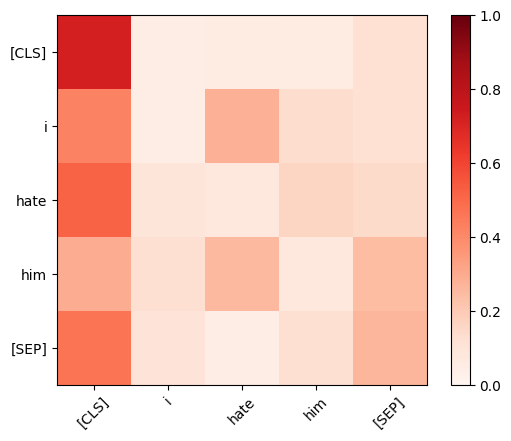

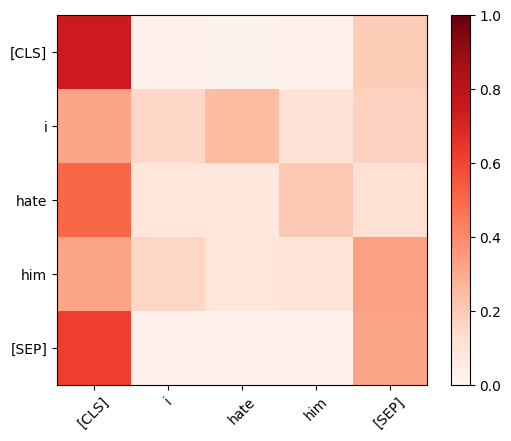

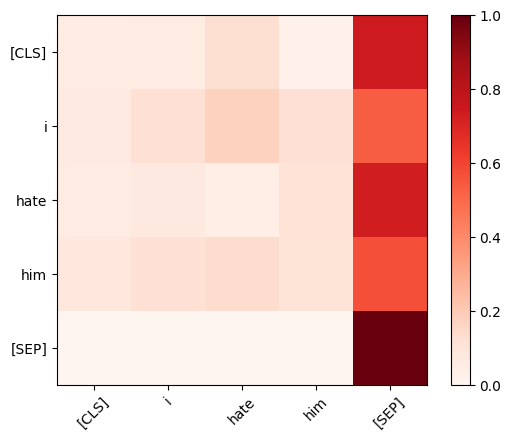

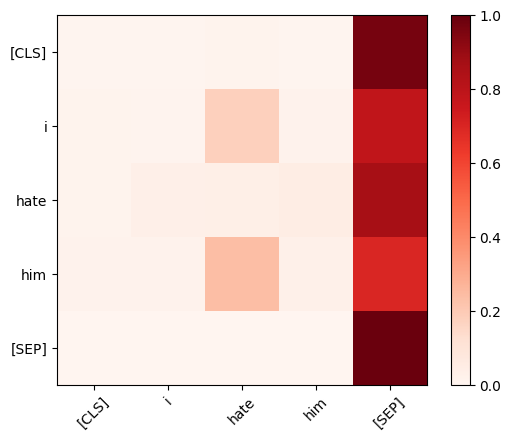

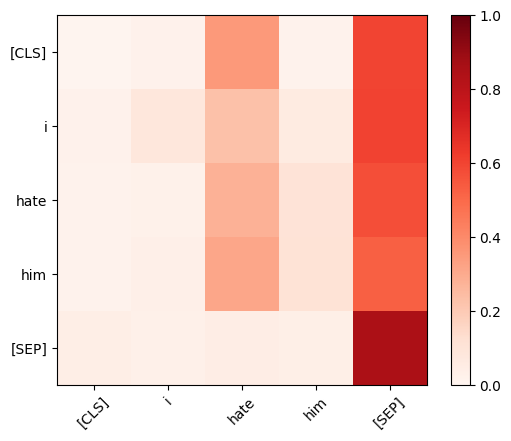

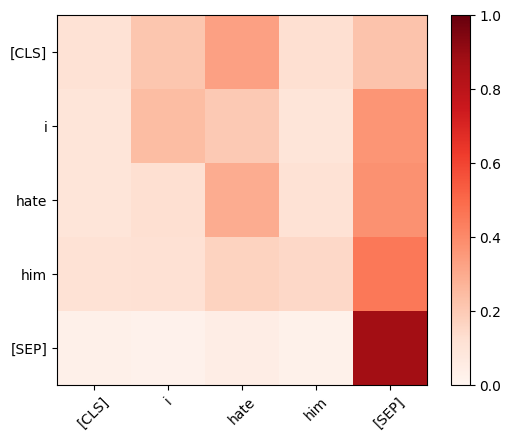

In [112]:
results = {0: "Negative", 1: "Positive"}
inputs2 = inputs2.to(config.device)
logits = model(inputs2['input_ids'])

print(f"Result is {results[torch.argmax(logits).item()]}")

att_probs = {i: [] for i in range(config.n_layers)}
for key, val in model.attention_probs.items():
    att_probs[key] = torch.mean(val, axis=1).squeeze(0).detach().cpu().numpy()
show_att_heatmaps(inputs2['input_ids'][0], att_probs)

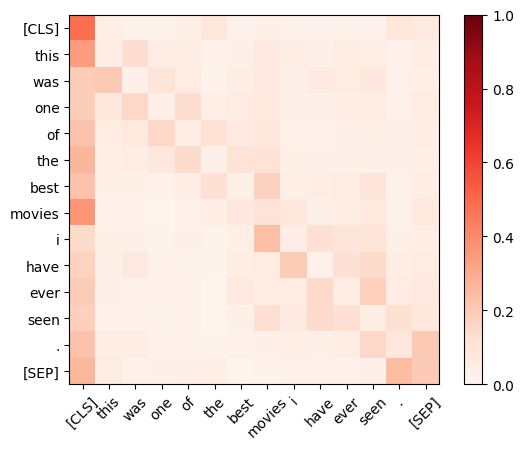

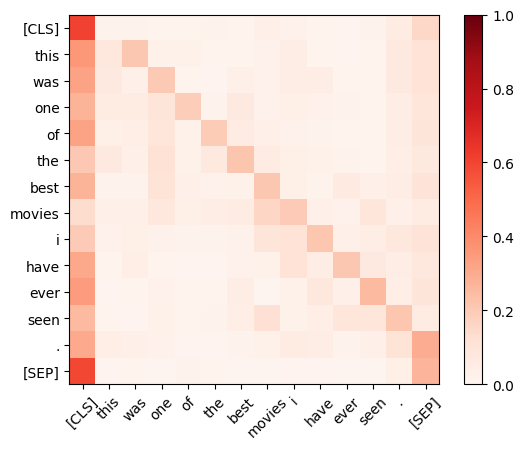

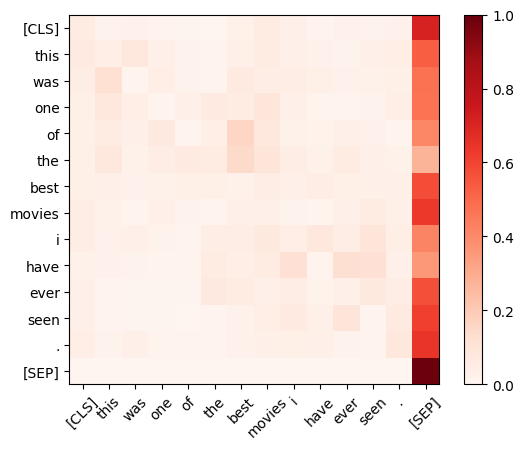

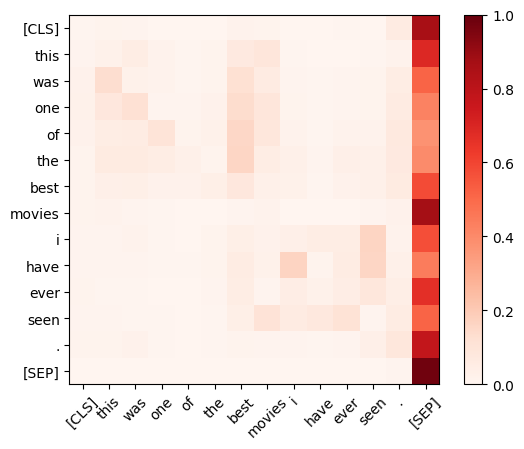

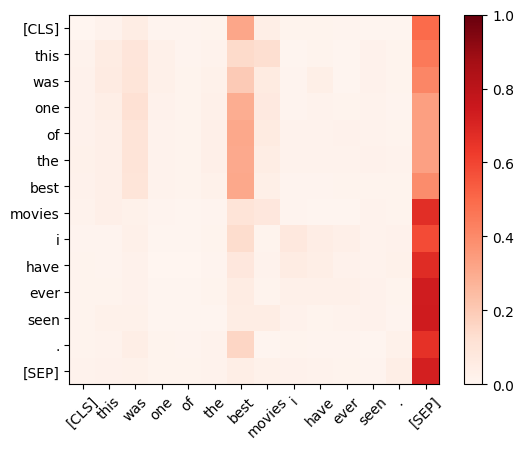

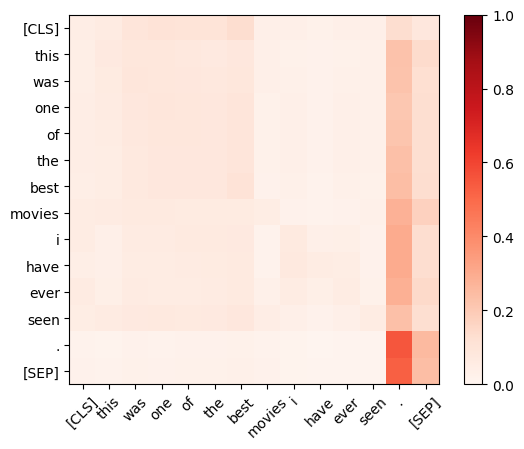

In [91]:
show_att_heatmaps(inputs['input_ids'][0], att_probs)